In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from collections import defaultdict
import time

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import umap
import hdbscan

### Load the dataset for exercises 10 to 13

In [4]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()

In [5]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [6]:
olivetti.images.shape

(400, 64, 64)

In [7]:
olivetti.data.shape

(400, 4096)

In [8]:
olivetti.target.shape

(400,)

Split into train, validation and test sets, 70%, 15% and 15%. 

In [9]:
X = olivetti.data
y = olivetti.target

In [10]:
train_size, dev_size = round(len(X) * 0.6), round(len(X) * 0.2)
test_size = len(X) - train_size - dev_size

In [11]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size+dev_size, stratify=y, shuffle=True, random_state=42)

# further split train set into actual train set and dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, train_size=train_size, stratify=y_train, shuffle=True, random_state=42)

### Exercise 10. cluster with kmeans

In [71]:
def train_cluster(cluster_array, trainset, clusterer_name = 'KMeans', plot=True):
    models = []
    metrics_per_model = defaultdict(list)

    if clusterer_name == 'KMeans':
        for k in cluster_array:
            clusterer = KMeans(n_clusters=k, random_state=42).fit(trainset)
            models.append(clusterer)
            metrics_per_model['Inertia'].append(clusterer.inertia_)
            metrics_per_model['Silhouette'].append(silhouette_score(trainset, clusterer.labels_))
    
    return models, metrics_per_model

def plot_kmeans(cluster_array, metrics_per_model):
    inertias_per_model = metrics_per_model['Inertia']
    silhouette_per_model = metrics_per_model['Silhouette']
    best_k_by_inertias, best_inertias = cluster_array[np.argmin(inertias_per_model)], min(inertias_per_model)
    best_k_by_silhouette, best_silhouette = cluster_array[np.argmax(silhouette_per_model)], max(silhouette_per_model)

    plt.figure(figsize=(15, 4))

    plt.subplot(121)
    plt.plot(cluster_array, inertias_per_model, 'bo-')
    plt.plot(best_k_by_inertias, best_inertias, 'ro')
    plt.title('Inertias')
    plt.xlabel('nr of clusters')

    plt.subplot(122)
    plt.plot(cluster_array, silhouette_per_model, 'go-')
    plt.plot(best_k_by_silhouette, best_silhouette, 'ro')
    plt.text(cluster_array[0], best_silhouette*0.9, s=f'Best Silhouette Score {best_silhouette:.3f}\nis obtained at {best_k_by_silhouette} clusters.', 
             fontdict={'fontsize': 10, 'color': 'darkgreen'})
    plt.title('Silhouette Score')
    plt.xlabel('nr of clusters')

#### Directly run kmeans on original dataset

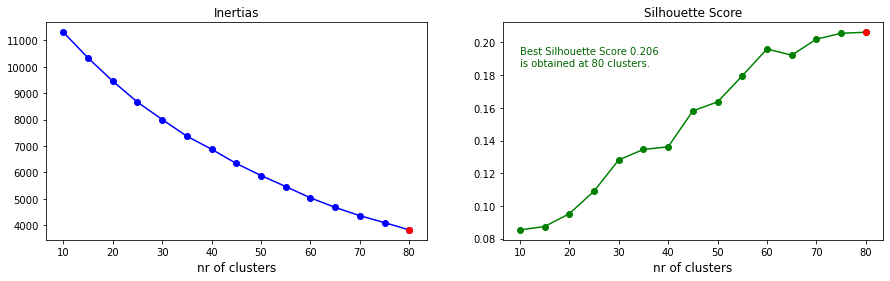

In [72]:
seq_n_clusters = np.arange(10, 81, 5)
kmeans_models, kmeans_metrics_per_model = train_cluster(seq_n_clusters, X_train)
plot_kmeans(seq_n_clusters, kmeans_metrics_per_model)

#### Dimension reduction then kmeans: pca vs umap

Would it be better if I perform dimension reduction before clustering?  

PCA with 99.0% variance kept has shrinked feature dimension from 4096 to 176.


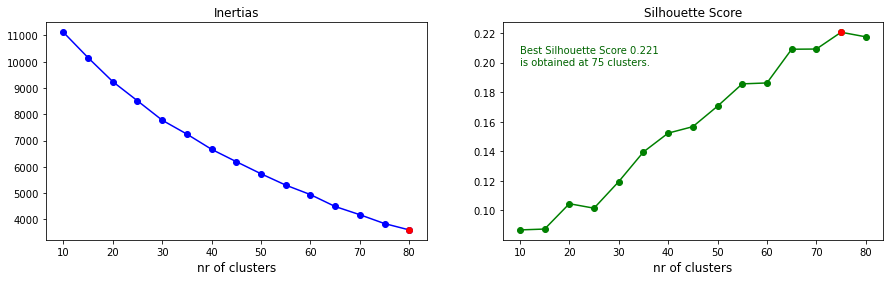

In [74]:
explained_variance = 0.99
pca = PCA(n_components=explained_variance, random_state=42)
X_train_pca = pca.fit_transform(X_train)
print(f'PCA with {explained_variance*100}% variance kept has shrinked feature dimension from {X_train.shape[1]} to {X_train_pca.shape[1]}.')

pca_kmeans_models, pca_kmeans_metrics_per_model = train_cluster(seq_n_clusters, X_train_pca)
plot_kmeans(seq_n_clusters, pca_kmeans_metrics_per_model)

PCA with 90.0% variance kept has shrinked feature dimension from 4096 to 56.


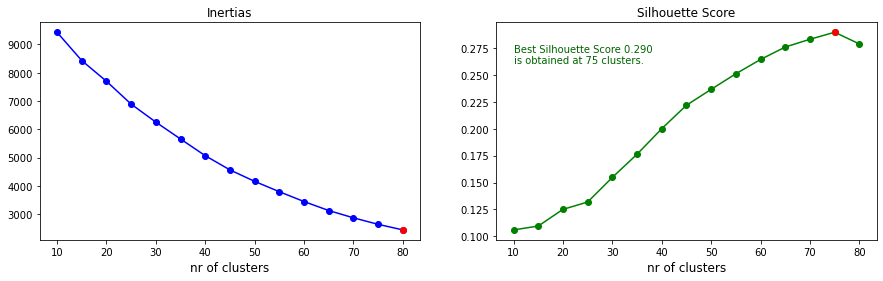

In [75]:
explained_variance = 0.9
pca = PCA(n_components=explained_variance, random_state=42)
X_train_pca = pca.fit_transform(X_train)
print(f'PCA with {explained_variance*100}% variance kept has shrinked feature dimension from {X_train.shape[1]} to {X_train_pca.shape[1]}.')

pca_kmeans_models, pca_kmeans_metrics_per_model = train_cluster(seq_n_clusters, X_train_pca)
plot_kmeans(seq_n_clusters, pca_kmeans_metrics_per_model)

Hmm, not more informative than without pca. Lets try umap, with the same nr of reduced features as in pca with 99% explained variance.

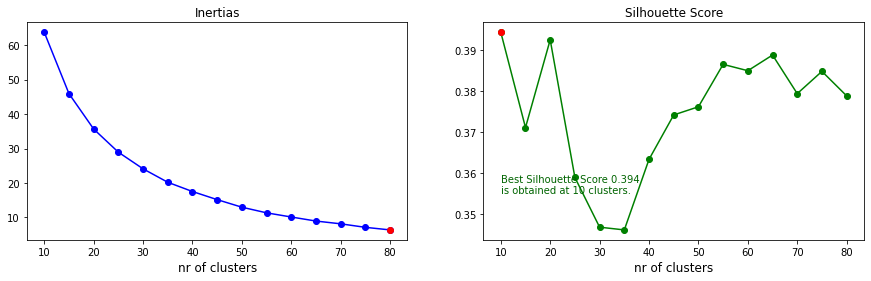

In [76]:
umap_ = umap.UMAP(n_components=176, min_dist=0, n_neighbors=30, random_state=42)
X_train_umap = umap_.fit_transform(X_train)

umap_kmeans_models, umap_kmeans_metrics_per_model = train_cluster(seq_n_clusters, X_train_umap)
plot_kmeans(seq_n_clusters, umap_kmeans_metrics_per_model)

Well, the Silhouette plot definitely gets more interesting, the Silhouette Score has increased from the pca + kmeans 0.22 to 0.39, which is a big boost. But the suggested n_cluster is 10, different from the ground truth (40). 

In [54]:
X_train.shape

(240, 4096)

In [80]:
kmeans_models[-2].labels_.max()

74

Cluster 0: 8 images


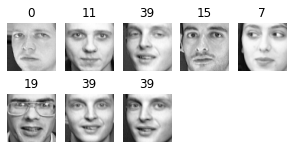

Cluster 1: 5 images


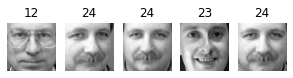

Cluster 2: 6 images


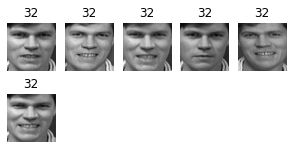

Cluster 3: 15 images


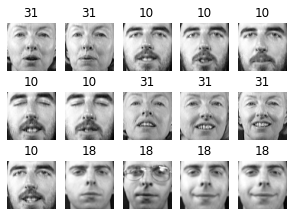

Cluster 4: 7 images


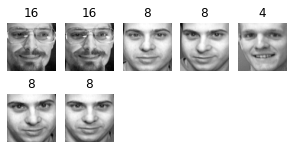

Cluster 5: 6 images


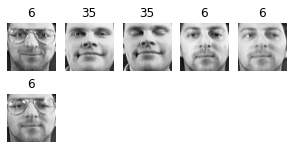

Cluster 6: 5 images


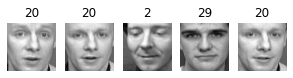

Cluster 7: 4 images


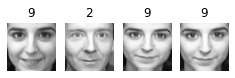

Cluster 8: 5 images


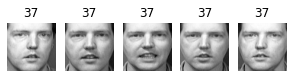

Cluster 9: 6 images


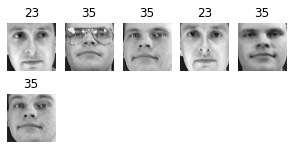

Cluster 10: 6 images


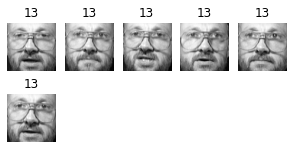

Cluster 11: 8 images


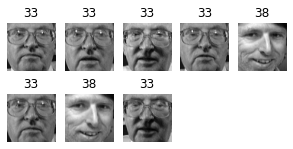

Cluster 12: 6 images


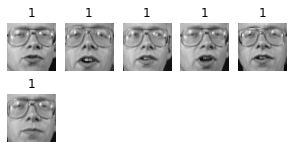

Cluster 13: 3 images


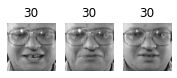

Cluster 14: 4 images


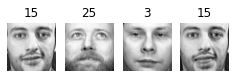

Cluster 15: 10 images


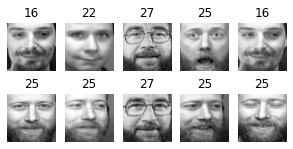

Cluster 16: 3 images


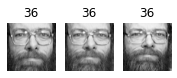

Cluster 17: 3 images


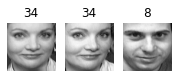

Cluster 18: 2 images


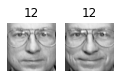

Cluster 19: 4 images


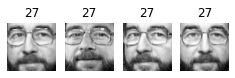

Cluster 20: 10 images


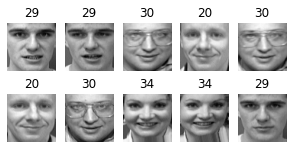

Cluster 21: 6 images


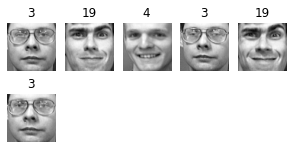

Cluster 22: 3 images


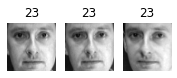

Cluster 23: 8 images


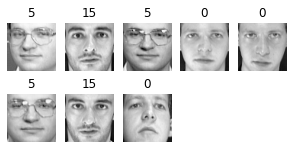

Cluster 24: 8 images


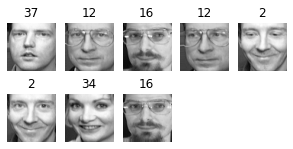

Cluster 25: 7 images


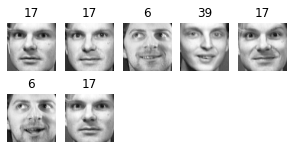

Cluster 26: 3 images


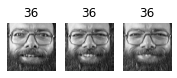

Cluster 27: 7 images


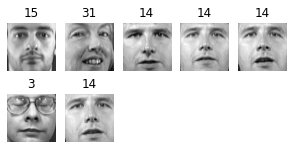

Cluster 28: 8 images


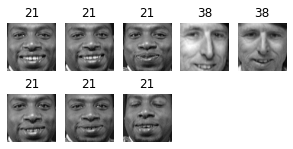

Cluster 29: 2 images


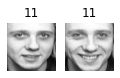

Cluster 30: 5 images


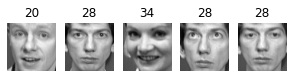

Cluster 31: 3 images


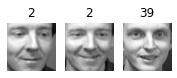

Cluster 32: 3 images


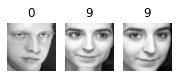

Cluster 33: 2 images


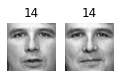

Cluster 34: 4 images


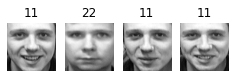

Cluster 35: 5 images


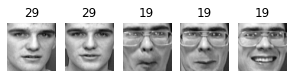

Cluster 36: 6 images


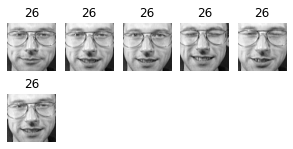

Cluster 37: 2 images


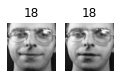

Cluster 38: 3 images


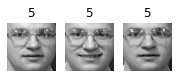

Cluster 39: 5 images


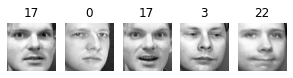

Cluster 40: 4 images


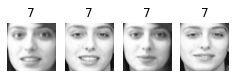

Cluster 41: 4 images


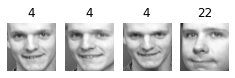

Cluster 42: 6 images


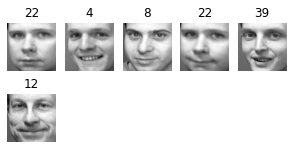

Cluster 43: 5 images


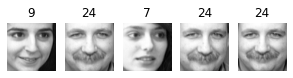

Cluster 44: 5 images


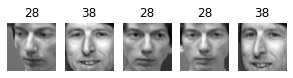

In [89]:
def plot_images(images, labels, n_cols=5):
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows*1.2))
    for idx, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(image.reshape(64, 64), cmap="gray")
        plt.axis('off')
        plt.title(label)
    plt.show()

best_model = umap_kmeans_models[7]

for cluster_id in np.unique(best_model.labels_):
    in_cluster = best_model.labels_ == cluster_id
    print(f'Cluster {cluster_id}: {np.sum(in_cluster)} images')
    images = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_images(images, labels)

#### Exercise 11. Ensemble models with kmeans as dimensionality reduction step

Directly train with xgboost to create baseline of performance

In [109]:
xgboost_clf = xgb.XGBClassifier(random_state=42, objective='multi:softmax', n_estimators=200)
xgboost_clf.fit(X_train, y_train)
y_dev_pred = xgboost_clf.predict(X_dev)
accuracy_score(y_dev, y_dev_pred)

0.7375

In [105]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_dev, y_dev)

0.95

Train RF after kmeans

We could use a `GridSearchCV`, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

**Kmeans then RF**

In [110]:
seq_n_clusters = np.arange(10, 151, 10)

for k in seq_n_clusters:
    pipeline = Pipeline([
        ('kmeans', KMeans(n_clusters=k, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=200))
    ])
    pipeline.fit(X_train, y_train)
    print(f"{k} clusters: {pipeline.score(X_dev, y_dev):.3f}")

10 clusters: 0.662
20 clusters: 0.738
30 clusters: 0.738
40 clusters: 0.812
50 clusters: 0.812
60 clusters: 0.825
70 clusters: 0.838
80 clusters: 0.812
90 clusters: 0.825
100 clusters: 0.850
110 clusters: 0.825
120 clusters: 0.863
130 clusters: 0.825
140 clusters: 0.838
150 clusters: 0.825


Oh well, even by tuning the number of clusters, we never get beyond 90% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images. What if I concat the distance features to the original ones? Pick the best number of clusters from the previous run, which is 120. 

In [111]:
kmeans_120 = KMeans(n_clusters=120, random_state=42).fit(X_train)

In [113]:
X_train_extended = np.c_[X_train, kmeans_120.transform(X_train)]
X_dev_extended = np.c_[X_dev, kmeans_120.transform(X_dev)]
X_test_extended = np.c_[X_test, kmeans_120.transform(X_test)]

In [114]:
clf = RandomForestClassifier(random_state=42, n_estimators=200).fit(X_train_extended, y_train)
clf.score(X_dev_extended, y_dev)

0.925

Still not as good as just using the original input features.

**UMAP then RF**

In [137]:
seq_n_clusters = np.arange(10, 151, 10)

for k in seq_n_clusters:
    pipeline = Pipeline([
        ('umap', umap.UMAP(n_components=k, n_neighbors=3, min_dist=0, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=200))
    ])
    pipeline.fit(X_train, y_train)
    print(f"{k} clusters: {pipeline.score(X_dev, y_dev):.3f}")

10 clusters: 0.787
20 clusters: 0.825
30 clusters: 0.838
40 clusters: 0.800
50 clusters: 0.800
60 clusters: 0.850
70 clusters: 0.812
80 clusters: 0.838
90 clusters: 0.787
100 clusters: 0.863
110 clusters: 0.800
120 clusters: 0.825
130 clusters: 0.850
140 clusters: 0.787
150 clusters: 0.800


#### Exercise 12. GMM and generate some new images

In [119]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
gm.fit(X_train_pca)

bayes_gm = BayesianGaussianMixture(n_components=80, n_init=5)
bayes_gm.fit(X_train_pca)

BayesianGaussianMixture(n_components=80, n_init=5)

So bayesian gmm estimates there are 80 clusters. 

In [141]:
np.count_nonzero(bayes_gm.weights_)

80

In [120]:
X_gen, y_gen = gm.sample(n_samples=20)
X_gen_bayes, y_gen_bayes = bayes_gm.sample(n_samples=20)

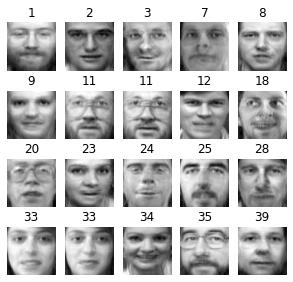

In [122]:
plot_images(pca.inverse_transform(X_gen), y_gen)

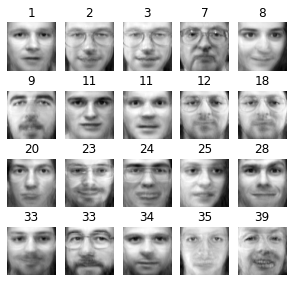

In [123]:
plot_images(pca.inverse_transform(X_gen_bayes), y_gen)

Create some anomaly images for gmm to detect

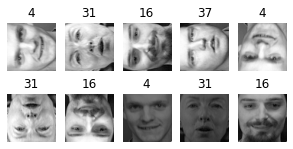

In [124]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_images(X_bad_faces, y_bad)

In [126]:
gm.score_samples(pca.transform(X_bad_faces))

array([-26703270.80443544, -25636929.90738903, -18921984.94662707,
       -36089306.58625112, -19211049.81856417, -36885722.1547722 ,
       -45198643.47826429, -52705094.25061282, -48647230.8353085 ,
       -56595790.04357278])

In [127]:
np.exp(gm.score_samples(pca.transform(X_bad_faces)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [133]:
gm.score_samples(X_train_pca[:5])

array([286.56004068, 285.12588919, 269.15857707, 233.25988437,
       313.97574193])